In [1]:
# main_2d.ipynb - planar reentry simulation driver

import os
import math
import importlib
import random

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import constants
import AtmosphereModel
import math_2d

# reload to pick up any edits made to the modules
importlib.reload(constants)
importlib.reload(AtmosphereModel)
importlib.reload(math_2d)


<module 'math_2d' from 'c:\\Users\\Risha\\Desktop\\ReEntryAI\\StochasticEntrySim\\math_2d.py'>

In [2]:
# data directory and csv helper functions

DATA_DIR = "data"
os.makedirs(DATA_DIR, exist_ok=True)

RUNS_CSV = os.path.join(DATA_DIR, "runs.csv")
TRAJ_CSV = os.path.join(DATA_DIR, "trajectories.csv")
STATE_CSV = os.path.join(DATA_DIR, "state_csv.csv")


def get_next_run_id() -> int:
    """Return the next integer run_id based on runs.csv."""
    if os.path.exists(RUNS_CSV):
        runs = pd.read_csv(RUNS_CSV)
        if runs.empty:
            return 1
        return int(runs["run_id"].max()) + 1
    else:
        return 1


def save_run(run_config: dict, history: dict) -> None:
    """
    Append one run to runs.csv and its time history to trajectories.csv.
    """
    run_id = run_config["run_id"]
    print("save_run called for run_id", run_id)

    runs_row = pd.DataFrame([run_config])
    if os.path.exists(RUNS_CSV):
        runs_row.to_csv(RUNS_CSV, mode="a", header=False, index=False)
    else:
        runs_row.to_csv(RUNS_CSV, index=False)

    traj_df = pd.DataFrame(
        {
            "run_id": run_id,
            "step_index": history["step_index"],
            "t_s": history["t_s"],
            "h_m": history["h_m"],
            "V_mps": history["V_mps"],
            "gamma_rad": history["gamma_rad"],
            "s_m": history["s_m"],
        }
    )

    if os.path.exists(TRAJ_CSV):
        traj_df.to_csv(TRAJ_CSV, mode="a", header=False, index=False)
    else:
        traj_df.to_csv(TRAJ_CSV, index=False)


def save_initial_state(run_id: int, init_state: dict) -> None:
    """
    Save one row with the initial state for a given run_id into state_csv.
    """
    print("save_initial_state called for run_id", run_id)

    row = {
        "run_id": run_id,
        "init_altitude_m": init_state["init_altitude_m"],
        "init_speed_mps": init_state["init_speed_mps"],
        "init_fpa_deg": init_state["init_fpa_deg"],
        "sigma_const_deg": init_state["sigma_const_deg"],
    }
    df = pd.DataFrame([row])
    if os.path.exists(STATE_CSV):
        df.to_csv(STATE_CSV, mode="a", header=False, index=False)
    else:
        df.to_csv(STATE_CSV, index=False)

In [3]:
def run_planar_sim(init_state: dict, do_plots: bool = True):
    """
    Run one planar reentry simulation.

    init_state must contain:
        - init_altitude_m
        - init_speed_mps
        - init_fpa_deg
        - sigma_const_deg
    """

    # basic case level parameters, normally from input.txt
    case_name        = "LEO_entry_test_01"
    t0_s             = 0.0
    dt_s             = 0.25
    t_final_s        = 2000.0

    min_altitude_m   = 0.0
    min_speed_mps    = 10.0

    # unpack randomized initial state
    init_altitude_m = init_state["init_altitude_m"]
    init_speed_mps  = init_state["init_speed_mps"]
    init_fpa_deg    = init_state["init_fpa_deg"]
    sigma_const_deg = init_state["sigma_const_deg"]

    # vehicle and environment parameters
    vehicle_params = {
        "mass_kg":     5000.0,
        "ref_area_m2": 10.0,
        "CL_const":    0.30,
        "CD_const":    1.00,
        "nose_radius_m": 1.0,
    }

    env_params = {
        "mu_m3s2":   3.986004418e14,
        "R_E_m":     6371000.0,
        "rho0_kgm3": 1.225,
        "H_m":       7200.0,
    }

    # initial state vector [h, V, gamma, s]
    y = [
        init_altitude_m,
        init_speed_mps,
        math.radians(init_fpa_deg),
        0.0,
    ]

    t = t0_s
    sigma = math.radians(sigma_const_deg)

    # history buffers
    history = {
        "step_index": [],
        "t_s": [],
        "h_m": [],
        "V_mps": [],
        "gamma_rad": [],
        "s_m": [],
    }

    # run metadata (one row per run)
    run_id = get_next_run_id()

    run_config = {
        "run_id": run_id,
        "case_name": case_name,
        "t0_s": t0_s,
        "dt_s": dt_s,
        "t_final_s": t_final_s,
        "init_altitude_m": init_altitude_m,
        "init_speed_mps": init_speed_mps,
        "init_fpa_deg": init_fpa_deg,
        "sigma_const_deg": sigma_const_deg,
        "mass_kg": vehicle_params["mass_kg"],
        "ref_area_m2": vehicle_params["ref_area_m2"],
        "CL_const": vehicle_params["CL_const"],
        "CD_const": vehicle_params["CD_const"],
    }

    # time stepping loop (forward euler)
    step = 0

    while t <= t_final_s:
        # log current state
        history["step_index"].append(step)
        history["t_s"].append(t)
        history["h_m"].append(y[0])
        history["V_mps"].append(y[1])
        history["gamma_rad"].append(y[2])
        history["s_m"].append(y[3])

        # stopping conditions
        if y[0] <= min_altitude_m or y[1] <= min_speed_mps:
            break

        # compute derivatives using planar rhs
        dy = math_2d.rhs_2d(t, y, sigma, vehicle_params, env_params)

        # forward euler step
        y = [yi + dt_s * dyi for yi, dyi in zip(y, dy)]
        t += dt_s
        step += 1

    # save to csv files
    save_run(run_config, history)
    save_initial_state(run_id, init_state)

    # optional plots for this run
    if do_plots:
        times = history["t_s"]
        alts  = history["h_m"]
        ranges = history["s_m"]

        plt.figure()
        plt.plot(times, alts)
        plt.xlabel("Time [s]")
        plt.ylabel("Altitude h [m]")
        plt.title("2D Planar Reentry: Altitude vs Time (run {0})".format(run_id))
        plt.grid(True)

        plt.figure()
        plt.plot(ranges, alts)
        plt.xlabel("Downrange s [m]")
        plt.ylabel("Altitude h [m]")
        plt.title("2D Planar Reentry Trajectory (run {0})".format(run_id))
        plt.grid(True)
        plt.gca().invert_yaxis()
        plt.show()

    return run_id, history


In [4]:
def plot_run(run_id: int):
    """Load trajectories for a given run_id from trajectories.csv and plot."""
    if not os.path.exists(TRAJ_CSV):
        print("No trajectories.csv file found.")
        return

    traj = pd.read_csv(TRAJ_CSV)
    run_traj = traj[traj["run_id"] == run_id]

    if run_traj.empty:
        print("No data found for run_id {0}".format(run_id))
        return

    times = run_traj["t_s"].values
    alts  = run_traj["h_m"].values
    ranges = run_traj["s_m"].values

    plt.figure()
    plt.plot(times, alts)
    plt.xlabel("Time [s]")
    plt.ylabel("Altitude h [m]")
    plt.title("2D Planar Reentry: Altitude vs Time (run {0})".format(run_id))
    plt.grid(True)

    plt.figure()
    plt.plot(ranges, alts)
    plt.xlabel("Downrange s [m]")
    plt.ylabel("Altitude h [m]")
    plt.title("2D Planar Reentry Trajectory (run {0})".format(run_id))
    plt.grid(True)
    # plt.gca().invert_yaxis()
    plt.show()


In [ ]:
# Monte Carlo style batch of runs with randomized initial states

N_RUNS = 10  # change this to run more or fewer cases

for k in range(N_RUNS):
    # sample a randomized initial state
    init_state = {
        "init_altitude_m": random.uniform(50000.0, 85000.0),
        "init_speed_mps":  random.uniform(7200.0, 7800.0),
        "init_fpa_deg":    random.uniform(-10.0, -1.0),
        "sigma_const_deg": random.uniform(0.0, 70.0),
    }

    run_id, _ = run_planar_sim(init_state=init_state, do_plots=False)
    print("Completed run_id {0}".format(run_id))

print("Completed {0} randomized runs.".format(N_RUNS))
# interval propagation, interval arithmetic

save_run called for run_id 102
save_initial_state called for run_id 102
Completed run_id 102
save_run called for run_id 103
save_initial_state called for run_id 103
Completed run_id 103
save_run called for run_id 104
save_initial_state called for run_id 104
Completed run_id 104
save_run called for run_id 105
save_initial_state called for run_id 105
Completed run_id 105
save_run called for run_id 106
save_initial_state called for run_id 106
Completed run_id 106
save_run called for run_id 107
save_initial_state called for run_id 107
Completed run_id 107
save_run called for run_id 108
save_initial_state called for run_id 108
Completed run_id 108
save_run called for run_id 109
save_initial_state called for run_id 109
Completed run_id 109
save_run called for run_id 110
save_initial_state called for run_id 110
Completed run_id 110
save_run called for run_id 111
save_initial_state called for run_id 111
Completed run_id 111
Completed 10 randomized runs.


save_run called for run_id 112
save_initial_state called for run_id 112


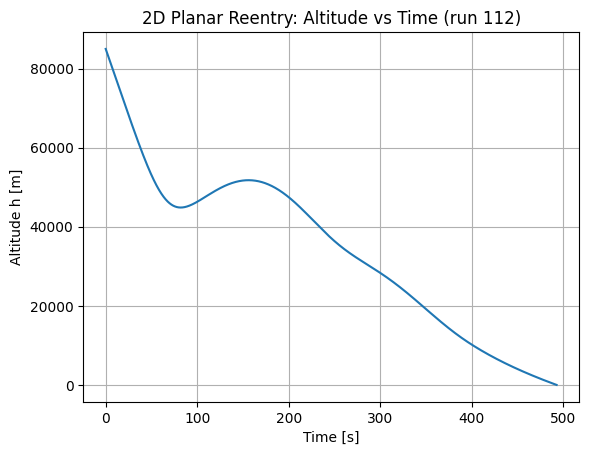

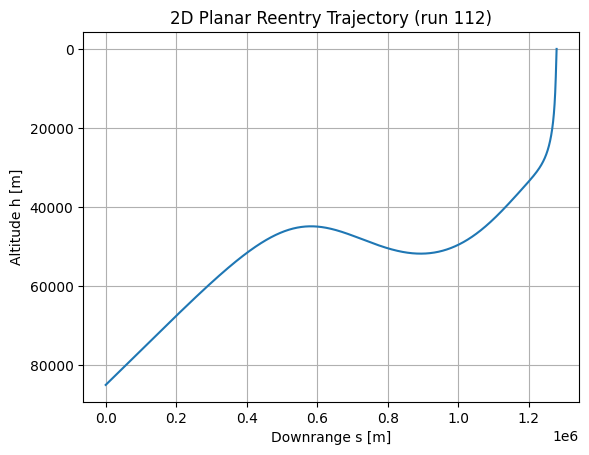

Example run_id: 112


In [ ]:
# example: one run with plots so you can inspect the trajectory

example_state = {
    "init_altitude_m": 85000.0,
    "init_speed_mps":  7700.0,
    "init_fpa_deg":    -5.0,
    "sigma_const_deg": 0.0,
}

run_id_example, history_example = run_planar_sim(init_state=example_state, do_plots=True)
print("Example run_id:", run_id_example)
# implement heating per cell as a gate, before taking the average and giving it to the reinforcement learning model

runs shape: (112, 13)
state_csv shape: (91, 5)
trajectories shape: (189943, 7)


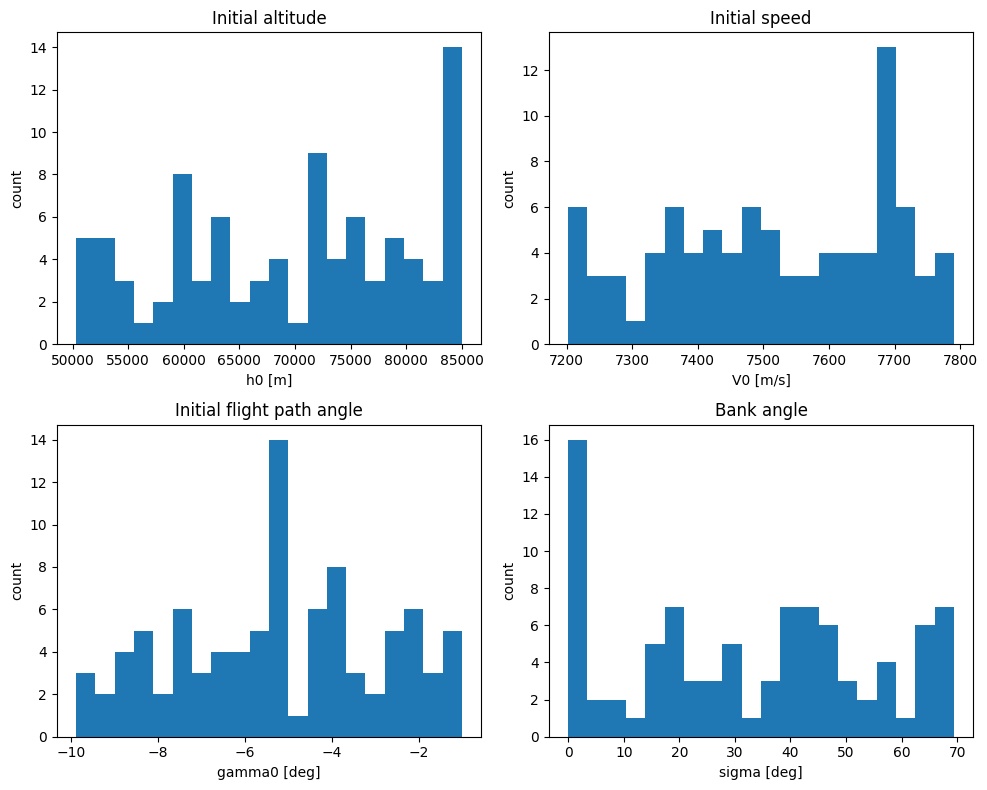

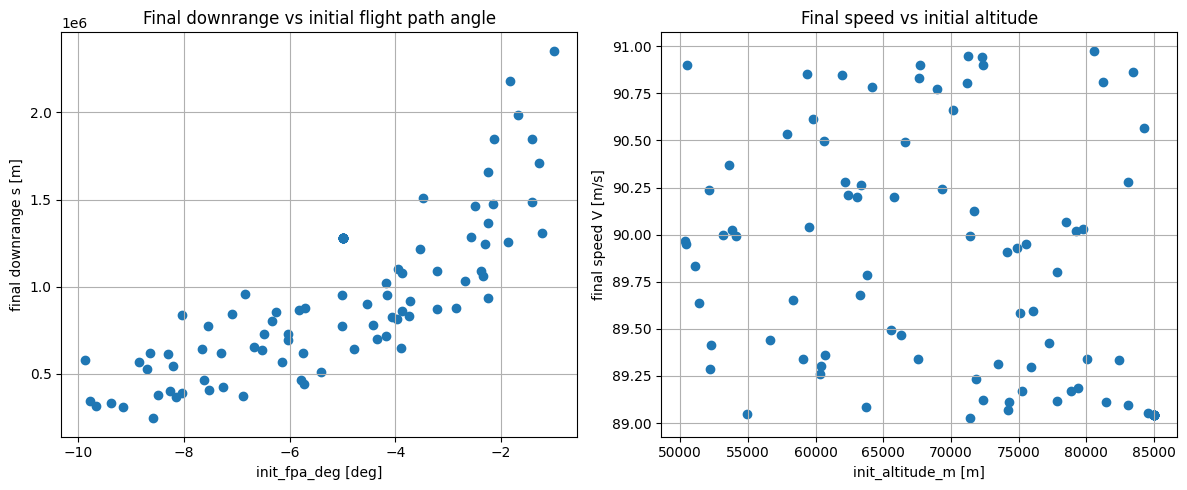

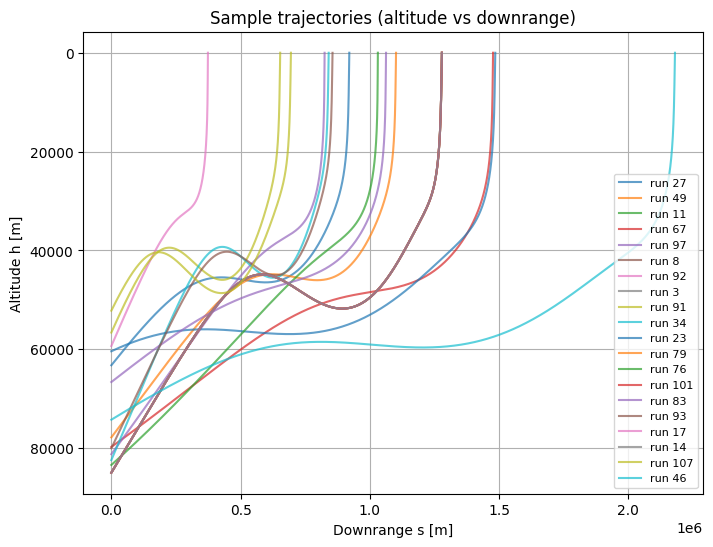

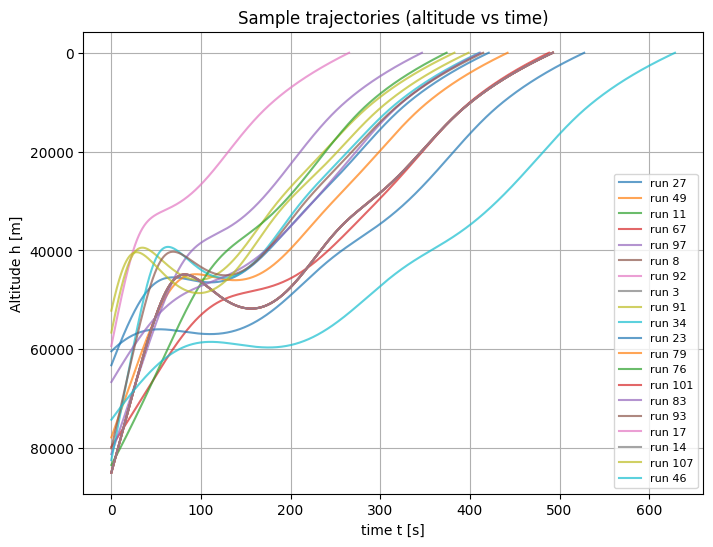

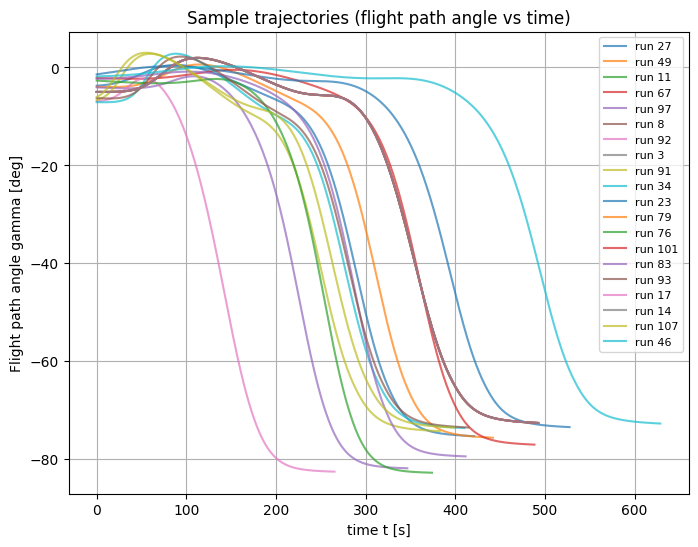

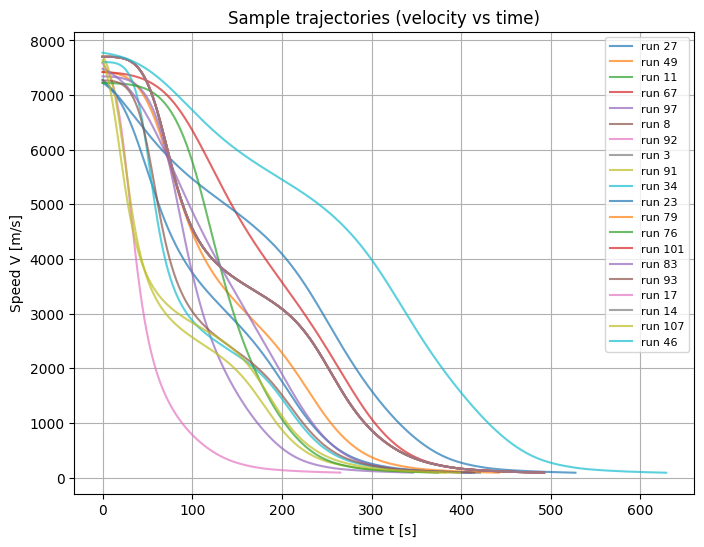

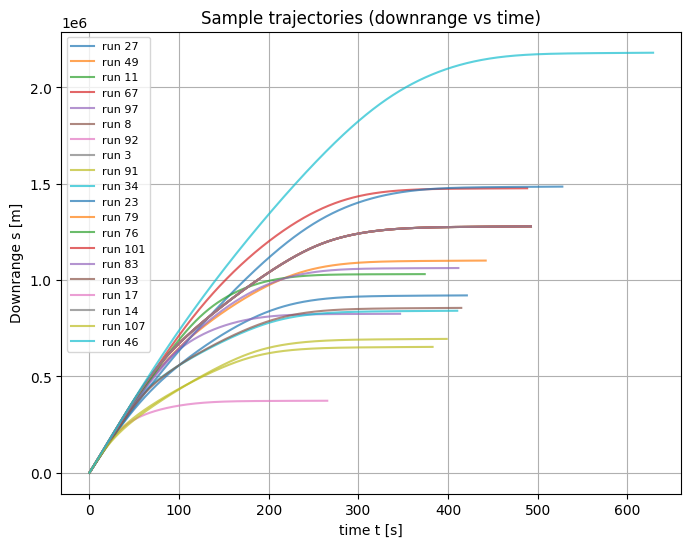

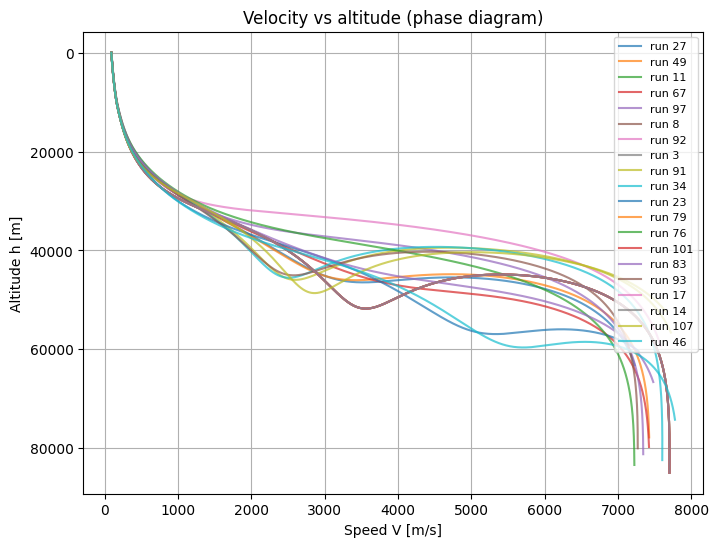

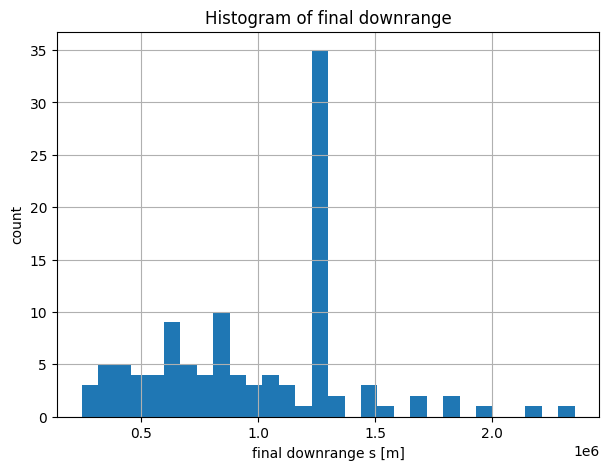

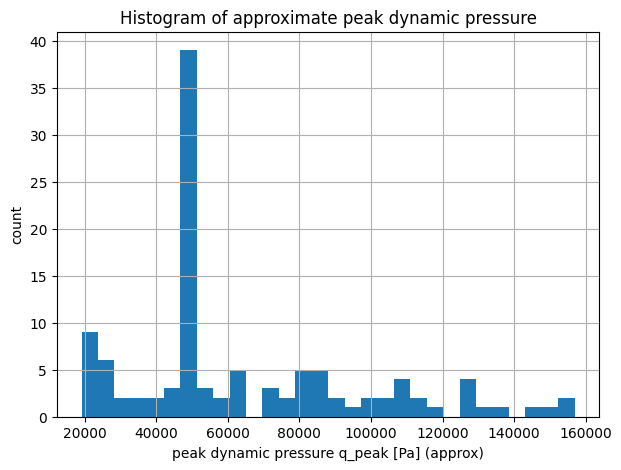

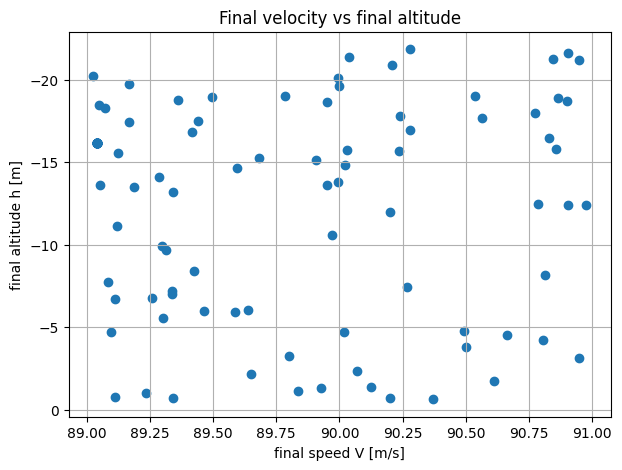

In [ ]:
# Basic EDA for planar reentry Monte Carlo data 

DATA_DIR = "data"
RUNS_CSV = os.path.join(DATA_DIR, "runs.csv")
TRAJ_CSV = os.path.join(DATA_DIR, "trajectories.csv")
STATE_CSV = os.path.join(DATA_DIR, "state_csv.csv")

runs = pd.read_csv(RUNS_CSV)
states = pd.read_csv(STATE_CSV)
traj = pd.read_csv(TRAJ_CSV)

print("runs shape:", runs.shape)
print("state_csv shape:", states.shape)
print("trajectories shape:", traj.shape)

# 1) Histograms of initial conditions (one row per run in states)
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

axes[0, 0].hist(states["init_altitude_m"], bins=20)
axes[0, 0].set_title("Initial altitude")
axes[0, 0].set_xlabel("h0 [m]")
axes[0, 0].set_ylabel("count")

axes[0, 1].hist(states["init_speed_mps"], bins=20)
axes[0, 1].set_title("Initial speed")
axes[0, 1].set_xlabel("V0 [m/s]")
axes[0, 1].set_ylabel("count")

axes[1, 0].hist(states["init_fpa_deg"], bins=20)
axes[1, 0].set_title("Initial flight path angle")
axes[1, 0].set_xlabel("gamma0 [deg]")
axes[1, 0].set_ylabel("count")

axes[1, 1].hist(states["sigma_const_deg"], bins=20)
axes[1, 1].set_title("Bank angle")
axes[1, 1].set_xlabel("sigma [deg]")
axes[1, 1].set_ylabel("count")

plt.tight_layout()
plt.show()

# 2) Final outcome table: one row per run (last time sample)
final = (
    traj
    .sort_values(["run_id", "t_s"])
    .groupby("run_id")
    .tail(1)
    .reset_index(drop=True)
)

merged = final.merge(states, on="run_id", how="left")

# 3) Final outcome scatter plots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].scatter(merged["init_fpa_deg"], merged["s_m"])
axes[0].set_xlabel("init_fpa_deg [deg]")
axes[0].set_ylabel("final downrange s [m]")
axes[0].set_title("Final downrange vs initial flight path angle")
axes[0].grid(True)

axes[1].scatter(merged["init_altitude_m"], merged["V_mps"])
axes[1].set_xlabel("init_altitude_m [m]")
axes[1].set_ylabel("final speed V [m/s]")
axes[1].set_title("Final speed vs initial altitude")
axes[1].grid(True)

plt.tight_layout()
plt.show()

# 4) Sample trajectories overlay: altitude vs downrange
unique_ids = traj["run_id"].unique()
n_sample = min(20, len(unique_ids))
sample_ids = pd.Series(unique_ids).sample(n=n_sample, random_state=0).values

plt.figure(figsize=(8, 6))
for rid in sample_ids:
    g = traj[traj["run_id"] == rid]
    plt.plot(g["s_m"], g["h_m"], alpha=0.7, label="run {0}".format(rid))

plt.xlabel("Downrange s [m]")
plt.ylabel("Altitude h [m]")
plt.title("Sample trajectories (altitude vs downrange)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend(loc="best", fontsize=8)
plt.show()

# 5) Sample trajectories overlay: altitude vs time
plt.figure(figsize=(8, 6))
for rid in sample_ids:
    g = traj[traj["run_id"] == rid]
    plt.plot(g["t_s"], g["h_m"], alpha=0.7, label="run {0}".format(rid))

plt.xlabel("time t [s]")
plt.ylabel("Altitude h [m]")
plt.title("Sample trajectories (altitude vs time)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend(loc="best", fontsize=8)
plt.show()

# 6) Sample trajectories overlay: flight path angle vs time
plt.figure(figsize=(8, 6))
for rid in sample_ids:
    g = traj[traj["run_id"] == rid]
    gamma_deg = np.rad2deg(g["gamma_rad"])
    plt.plot(g["t_s"], gamma_deg, alpha=0.7, label="run {0}".format(rid))

plt.xlabel("time t [s]")
plt.ylabel("Flight path angle gamma [deg]")
plt.title("Sample trajectories (flight path angle vs time)")
plt.grid(True)
plt.legend(loc="best", fontsize=8)
plt.show()

# 7) Sample trajectories overlay: velocity vs time
plt.figure(figsize=(8, 6))
for rid in sample_ids:
    g = traj[traj["run_id"] == rid]
    plt.plot(g["t_s"], g["V_mps"], alpha=0.7, label="run {0}".format(rid))

plt.xlabel("time t [s]")
plt.ylabel("Speed V [m/s]")
plt.title("Sample trajectories (velocity vs time)")
plt.grid(True)
plt.legend(loc="best", fontsize=8)
plt.show()

# 8) Sample trajectories overlay: downrange vs time
plt.figure(figsize=(8, 6))
for rid in sample_ids:
    g = traj[traj["run_id"] == rid]
    plt.plot(g["t_s"], g["s_m"], alpha=0.7, label="run {0}".format(rid))

plt.xlabel("time t [s]")
plt.ylabel("Downrange s [m]")
plt.title("Sample trajectories (downrange vs time)")
plt.grid(True)
plt.legend(loc="best", fontsize=8)
plt.show()

# 9) Velocity vs altitude phase diagram (classic reentry view)
plt.figure(figsize=(8, 6))
for rid in sample_ids:
    g = traj[traj["run_id"] == rid]
    plt.plot(g["V_mps"], g["h_m"], alpha=0.7, label="run {0}".format(rid))

plt.xlabel("Speed V [m/s]")
plt.ylabel("Altitude h [m]")
plt.title("Velocity vs altitude (phase diagram)")
plt.gca().invert_yaxis()
plt.grid(True)
plt.legend(loc="best", fontsize=8)
plt.show()

# 10) Histogram of final downrange
plt.figure(figsize=(7, 5))
plt.hist(merged["s_m"], bins=30)
plt.xlabel("final downrange s [m]")
plt.ylabel("count")
plt.title("Histogram of final downrange")
plt.grid(True)
plt.show()

# 11) Approximate peak dynamic pressure per run and histogram
# Simple exponential atmosphere model for density:
#   rho(h) = rho0 * exp(-h / H)
# This is an approximation used just for EDA.
rho0 = 1.225      # kg/m^3, sea level
H_scale = 7500.0  # m, scale height

rho = rho0 * np.exp(-traj["h_m"] / H_scale)
q_pa = 0.5 * rho * traj["V_mps"]**2  # dynamic pressure in Pascals
traj["q_pa_approx"] = q_pa

peak_q = (
    traj
    .groupby("run_id")["q_pa_approx"]
    .max()
    .reset_index(name="q_peak_pa")
)

plt.figure(figsize=(7, 5))
plt.hist(peak_q["q_peak_pa"], bins=30)
plt.xlabel("peak dynamic pressure q_peak [Pa] (approx)")
plt.ylabel("count")
plt.title("Histogram of approximate peak dynamic pressure")
plt.grid(True)
plt.show()

# 12) Joint scatter of final velocity vs final altitude
plt.figure(figsize=(7, 5))
plt.scatter(merged["V_mps"], merged["h_m"])
plt.xlabel("final speed V [m/s]")
plt.ylabel("final altitude h [m]")
plt.title("Final velocity vs final altitude")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()
# parachute specifications

Correlation matrix:
                 init_altitude_m  init_speed_mps  init_fpa_deg  \
init_altitude_m            1.000           0.206         0.157   
init_speed_mps             0.206           1.000        -0.029   
init_fpa_deg               0.157          -0.029         1.000   
sigma_const_deg           -0.386          -0.216        -0.059   
h_m                       -0.017          -0.289        -0.003   
V_mps                     -0.305          -0.162        -0.084   
s_m                        0.503           0.145         0.795   

                 sigma_const_deg    h_m  V_mps    s_m  
init_altitude_m           -0.386 -0.017 -0.305  0.503  
init_speed_mps            -0.216 -0.289 -0.162  0.145  
init_fpa_deg              -0.059 -0.003 -0.084  0.795  
sigma_const_deg            1.000 -0.005  0.983 -0.507  
h_m                       -0.005  1.000  0.113 -0.121  
V_mps                      0.983  0.113  1.000 -0.570  
s_m                       -0.507 -0.121 -0.570  1.000  


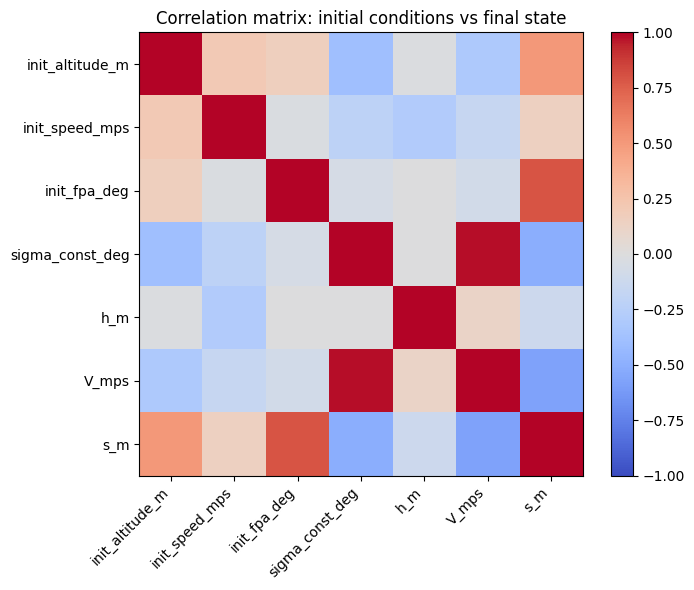


NaN counts for downrange regression columns:
init_fpa_deg       21
sigma_const_deg    21
s_m                 0
dtype: int64

Linear regression: final downrange s_m ~ init_fpa_deg + sigma_const_deg
Intercept: 1978919.5369820152
coef for init_fpa_deg: 144066.52608437673
coef for sigma_const_deg: -9159.423456180753
R^2: 0.8438087923863024


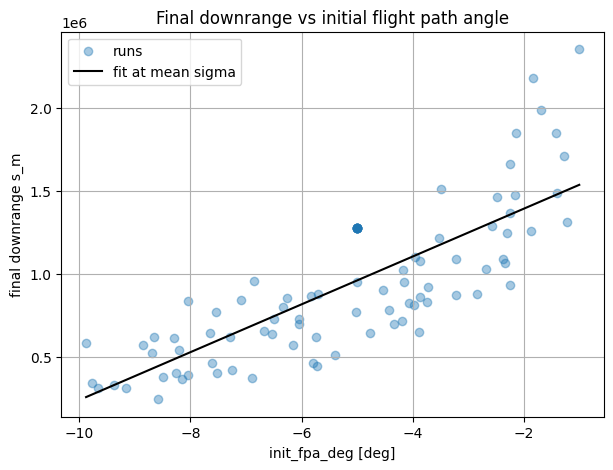


NaN counts for speed regression columns:
init_speed_mps     21
sigma_const_deg    21
V_mps               0
dtype: int64

Linear regression: final speed V_mps ~ init_speed_mps + sigma_const_deg
Intercept: 87.35423629162537
coef for init_speed_mps: 0.0002012771944609483
coef for sigma_const_deg: 0.028968977545303292
R^2: 0.9699071853149475


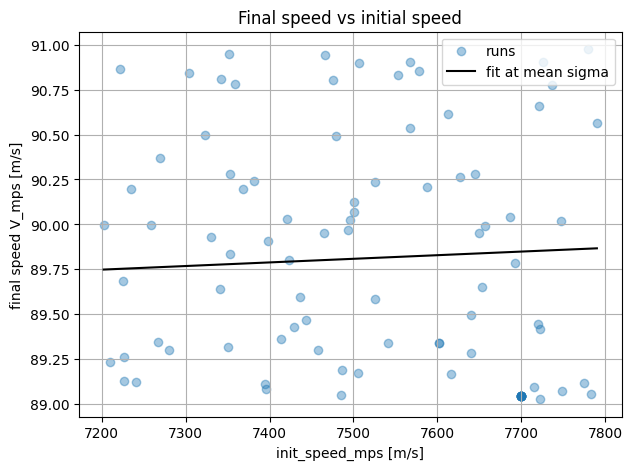

In [ ]:
# Correlations and simple linear regressions

import numpy as np
from sklearn.linear_model import LinearRegression

# merged already has one row per run: final state + initial conditions
# If this cell is re-run, rebuild merged to avoid stale data.
final = (
    traj.sort_values(["run_id", "t_s"])
        .groupby("run_id")
        .tail(1)
        .reset_index(drop=True)
)
merged = final.merge(states, on="run_id", how="left")

# 1) Correlation matrix
# Columns that connect initial conditions to final state.
corr_cols = [
    "init_altitude_m",
    "init_speed_mps",
    "init_fpa_deg",
    "sigma_const_deg",
    "h_m",        # final altitude
    "V_mps",      # final speed
    "s_m",        # final downrange
]

# pandas corr ignores rows with NaN on a pairwise basis, so this is safe.
corr = merged[corr_cols].corr()

print("Correlation matrix:")
print(corr.round(3))

plt.figure(figsize=(8, 6))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr_cols)), corr_cols, rotation=45, ha="right")
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Correlation matrix: initial conditions vs final state")
plt.tight_layout()
plt.show()

# 2) Linear regression:
#    final downrange vs initial fpa and bank angle
# Select only the columns needed for this regression.
cols_s = ["init_fpa_deg", "sigma_const_deg", "s_m"]

# Drop any rows that have missing values in these columns.
print("\nNaN counts for downrange regression columns:")
print(merged[cols_s].isna().sum())
clean_s = merged.dropna(subset=cols_s)

# Design matrix: predictors are initial fpa and bank.
X_s = clean_s[["init_fpa_deg", "sigma_const_deg"]].values
# Target: final downrange.
y_s = clean_s["s_m"].values

model_s = LinearRegression()
model_s.fit(X_s, y_s)

print("\nLinear regression: final downrange s_m ~ init_fpa_deg + sigma_const_deg")
print("Intercept:", model_s.intercept_)
print("coef for init_fpa_deg:", model_s.coef_[0])
print("coef for sigma_const_deg:", model_s.coef_[1])
print("R^2:", model_s.score(X_s, y_s))

# Plot a one dimensional slice: vary fpa at fixed bank (mean sigma).
mean_sigma = clean_s["sigma_const_deg"].mean()
fpa_grid = np.linspace(clean_s["init_fpa_deg"].min(),
                       clean_s["init_fpa_deg"].max(), 50)
X_grid = np.column_stack([fpa_grid, np.full_like(fpa_grid, mean_sigma)])
s_pred = model_s.predict(X_grid)

plt.figure(figsize=(7, 5))
plt.scatter(clean_s["init_fpa_deg"], clean_s["s_m"],
            alpha=0.4, label="runs")
plt.plot(fpa_grid, s_pred, color="black",
         label="fit at mean sigma")
plt.xlabel("init_fpa_deg [deg]")
plt.ylabel("final downrange s_m")
plt.title("Final downrange vs initial flight path angle")
plt.grid(True)
plt.legend()
plt.show()

# 3) Linear regression:
#    final speed vs initial speed and bank angle
# Columns needed for the speed regression.
cols_v = ["init_speed_mps", "sigma_const_deg", "V_mps"]

print("\nNaN counts for speed regression columns:")
print(merged[cols_v].isna().sum())
clean_v = merged.dropna(subset=cols_v)

# Design matrix: predictors are initial speed and bank.
X_v = clean_v[["init_speed_mps", "sigma_const_deg"]].values
# Target: final speed.
y_v = clean_v["V_mps"].values

model_v = LinearRegression()
model_v.fit(X_v, y_v)

print("\nLinear regression: final speed V_mps ~ init_speed_mps + sigma_const_deg")
print("Intercept:", model_v.intercept_)
print("coef for init_speed_mps:", model_v.coef_[0])
print("coef for sigma_const_deg:", model_v.coef_[1])
print("R^2:", model_v.score(X_v, y_v))

# Plot a one dimensional slice: vary initial speed at fixed bank (mean sigma).
mean_sigma_v = clean_v["sigma_const_deg"].mean()
v0_grid = np.linspace(clean_v["init_speed_mps"].min(),
                      clean_v["init_speed_mps"].max(), 50)
Xv_grid = np.column_stack([v0_grid, np.full_like(v0_grid, mean_sigma_v)])
V_pred = model_v.predict(Xv_grid)

plt.figure(figsize=(7, 5))
plt.scatter(clean_v["init_speed_mps"], clean_v["V_mps"],
            alpha=0.4, label="runs")
plt.plot(v0_grid, V_pred, color="black",
         label="fit at mean sigma")
plt.xlabel("init_speed_mps [m/s]")
plt.ylabel("final speed V_mps [m/s]")
plt.title("Final speed vs initial speed")
plt.grid(True)
plt.legend()
plt.show()
